# 本实验演示了视觉伺服系统传统的目标定位流程

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import ipywidgets
from ipywidgets import interact
%matplotlib inline

# 1 数据读取，将彩色图像转换为灰度图像，使用matplotlib进行显示

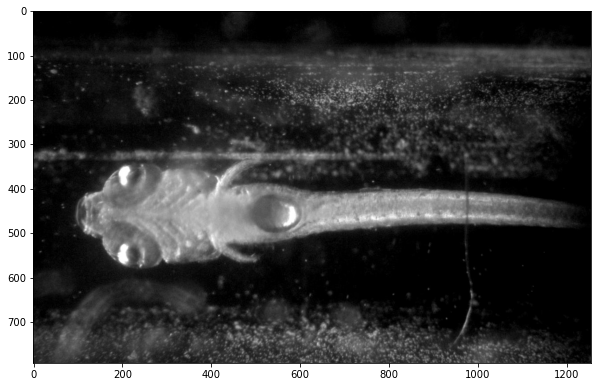

In [2]:
img_origin = cv.imread("./data/frame0-00-07.60.jpg") #读取图像，存入img_origin
img_origin[:,:,0],img_origin[:,:,1],img_origin[:,:,2]=img_origin[:,:,2],img_origin[:,:,1],img_origin[:,:,0] #RGB通道顺序调整，方便显示
img_gray=cv.cvtColor(img_origin,cv.COLOR_BGR2GRAY) #彩色图像转换为灰度图像
plt.figure("Image",figsize=(10, 10)) # 建立画布，设置窗口大小
plt.imshow(img_origin) #显示图像

# 2 高斯滤波，模糊图像去噪声，
### 参数x调整卷积核宽度（2x+1）
### 参数y调整卷积核高度（2y+1）
### x和y方向标准差根据卷积核大小自动进行计算，也可用户自行设置
### 输入为img_gray，输出为img_blur

In [3]:
img_blur=img_gray.copy()

def IntSlider(value, **kwargs):
    """ 
    Creates an ipwidgets IntSlider with continuous update
    turned off
    """
    return ipywidgets.IntSlider(value, continuous_update=False, **kwargs)

def interactive_blur(x,y):
    global img_blur, img_gray
    fig = plt.figure("Blur",figsize=(20, 20))
    if img_blur is not None: plt.close(fig)
    img_blur = cv.GaussianBlur(img_gray, (2*int(x)+1, 2*int(y)+1), 0) #使用高斯滤波处理输入img_gray，输出为img_blur
    
    plt.imshow(img_blur,cmap='gray')
    

interact(interactive_blur,           
         x=IntSlider(value=50, min=0, max=50), 
         y=IntSlider(value=50, min=0, max=50), 
         );

interactive(children=(IntSlider(value=50, continuous_update=False, description='x', max=50), IntSlider(value=5…

# 3 图像二值化操作，白色为前景，黑色为背景

## 方法1 手动设置阈值，输入为img_blur，输出为img_bin，阈值thresh由滑动条进行设置

In [4]:
img_bin = np.zeros_like(img_blur)
def interactive_manual(thresh):
    global img_blur,img_bin
    fig = plt.figure("Binary",figsize=(20, 20))
    if img_bin is not None: plt.close(fig)
    ret, img_bin = cv.threshold(img_blur, thresh, 255, cv.THRESH_BINARY_INV)
    plt.imshow(img_bin,cmap='gray')
    
interact(interactive_manual,            
         thresh=IntSlider(value=51, min=0, max=255), 
         );

interactive(children=(IntSlider(value=51, continuous_update=False, description='thresh', max=255), Output()), …

## 方法2 自适应阈值操作，输入为img_blur，输出为img_bin
### blocksize设置窗口大小（2* blocksize + 1），根据窗口内的像素分布计算中心像素的阈值
### thresh为减去的偏移值
#### ADAPTIVE_THRESH_MEAN_C的计算方法是计算出领域的平均值再减去参数thresh的值
#### ADAPTIVE_THRESH_GAUSSIAN_C的计算方法是计算出领域的高斯均值减去参数thresh的值

In [7]:
img_bin = np.zeros_like(img_blur)
def interactive_adapt(blocksize,thresh):
    global img_blur,img_bin
    fig = plt.figure("Binary",figsize=(20, 20))
    if img_bin is not None: plt.close(fig)
    img_bin = cv.adaptiveThreshold(img_blur, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 2*int(blocksize)+1, int(thresh))
    plt.imshow(img_bin,cmap='gray')
    
interact(interactive_adapt,           
         blocksize=IntSlider(value=10, min=0, max=50), 
         thresh=IntSlider(value=20, min=0, max=100), 
         );

interactive(children=(IntSlider(value=10, continuous_update=False, description='blocksize', max=50), IntSlider…

# 3 形态学操作，用于去噪和处理连通域形态，输入为img_bin，输出为img_morph

## 方法1 形态学膨胀，参数x为x方向膨胀系数，参数y为y方向膨胀系数

In [5]:
img_morph = img_bin.copy()
def interactive_morph_dilate(x,y):
    global img_morph,img_bin
    fig = plt.figure("Binary",figsize=(20, 20))
    if img_morph is not None: plt.close(fig)
    se = cv.getStructuringElement(cv.MORPH_RECT, (x, y), (-1, -1))
    img_morph = cv.morphologyEx(img_bin, cv.MORPH_DILATE, se)
    plt.imshow(img_morph,cmap='gray')
    
interact(interactive_morph_dilate,           
         x=IntSlider(value=1, min=1, max=100), 
         y=IntSlider(value=1, min=1, max=100), 
         );

interactive(children=(IntSlider(value=1, continuous_update=False, description='x', min=1), IntSlider(value=1, …

## 方法2 形态学腐蚀，参数x为x方向腐蚀系数，参数y为y方向腐蚀系数

In [7]:
img_morph = img_bin.copy()
def interactive_morph_erode(x,y):
    global img_morph,img_bin
    fig = plt.figure("Binary",figsize=(20, 20))
    if img_morph is not None: plt.close(fig)
    se = cv.getStructuringElement(cv.MORPH_RECT, (x, y), (-1, -1))
    img_morph = cv.morphologyEx(img_bin, cv.MORPH_ERODE, se)
    plt.imshow(img_morph,cmap='gray')
    
interact(interactive_morph_erode,           
         x=IntSlider(value=1, min=1, max=100), 
         y=IntSlider(value=1, min=1, max=100), 
         );

interactive(children=(IntSlider(value=1, continuous_update=False, description='x', min=1), IntSlider(value=1, …

## 方法3 形态学闭运算，先膨胀后腐蚀
## 参数x_dilate为x方向膨胀系数，参数y_dilate为y方向膨胀系数
## 参数x_dilate为x方向膨胀系数，参数y_dilate为y方向膨胀系数

In [19]:
img_morph = img_bin.copy()
def interactive_morph_dilate_erode(x_dilate,y_dilate,x_erode,y_erode):
    global img_morph,img_bin
    fig = plt.figure("Binary",figsize=(20, 20))
    if img_morph is not None: plt.close(fig)
    se_dilate = cv.getStructuringElement(cv.MORPH_RECT, (x_dilate, y_dilate), (-1, -1))
    img_morph = cv.morphologyEx(img_bin, cv.MORPH_DILATE, se_dilate)
    se_erode = cv.getStructuringElement(cv.MORPH_RECT, (x_erode, y_erode), (-1, -1))
    img_morph = cv.morphologyEx(img_morph, cv.MORPH_ERODE, se_erode)    
    
    plt.imshow(img_morph,cmap='gray')
    
interact(interactive_morph_dilate_erode,           
         x_dilate=IntSlider(value=1, min=1, max=100), 
         y_dilate=IntSlider(value=1, min=1, max=100),
         x_erode=IntSlider(value=1, min=1, max=100), 
         y_erode=IntSlider(value=1, min=1, max=100), 
         );

interactive(children=(IntSlider(value=1, continuous_update=False, description='x_dilate', min=1), IntSlider(va…

## 方法4 形态学开运算，先腐蚀后膨胀
## 参数x_dilate为x方向膨胀系数，参数y_dilate为y方向膨胀系数
## 参数x_dilate为x方向膨胀系数，参数y_dilate为y方向膨胀系数

In [8]:
img_morph = img_bin.copy()
def interactive_morph_erode_dilate(x_erode,y_erode,x_dilate,y_dilate):
    global img_morph,img_bin
    fig = plt.figure("Binary",figsize=(20, 20))
    if img_morph is not None: plt.close(fig)
    se_erode = cv.getStructuringElement(cv.MORPH_RECT, (x_erode, y_erode), (-1, -1))
    img_morph = cv.morphologyEx(img_bin, cv.MORPH_ERODE, se_erode)   
    se_dilate = cv.getStructuringElement(cv.MORPH_RECT, (x_dilate, y_dilate), (-1, -1))
    img_morph = cv.morphologyEx(img_morph, cv.MORPH_DILATE, se_dilate)
 
    plt.imshow(img_morph,cmap='gray')
    
interact(interactive_morph_erode_dilate,   
         x_erode=IntSlider(value=97, min=1, max=100), 
         y_erode=IntSlider(value=84, min=1, max=100), 
         x_dilate=IntSlider(value=46, min=1, max=100), 
         y_dilate=IntSlider(value=50, min=1, max=100)
         );

interactive(children=(IntSlider(value=97, continuous_update=False, description='x_erode', min=1), IntSlider(va…

# 4 根据处理后的二值化图像进行目标定位，输出图像为img_show
## （此步骤已经写好，不需要用户进行操作）

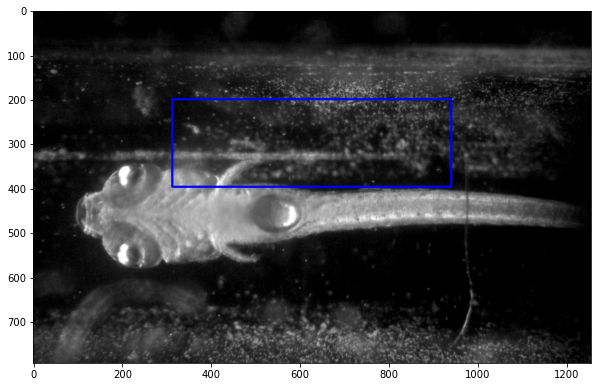

In [9]:
mask_and = np.zeros_like(img_bin)
img_findcontour=np.zeros_like(img_bin)
mask = np.zeros_like(img_bin)

height, width = img_bin.shape
cv.rectangle(mask_and, (int(width/4), int(height/4)), (int(width/4*3), int(height/4*3)), (255), -1)#矩形
img_findcontour=cv.bitwise_and(img_morph,mask_and)

contours, hierarchy = cv.findContours(img_findcontour, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
index = 0
max_area = 0
for c in range(len(contours)):
    area = cv.contourArea(contours[c])
    if area > max_area:
        max_area = area
        index = c
cv.drawContours(mask, contours, index, (255), -1)

img_show = img_origin.copy()

rect = cv.minAreaRect(contours[index])
box = cv.boxPoints(rect)
box = np.int0(box)
cv.drawContours(img_show,[box],0,(0,0,255),3)

plt.figure("img_show",figsize=(10, 10)) # 图像窗口名称
plt.imshow(img_show)

# 期望输出图像

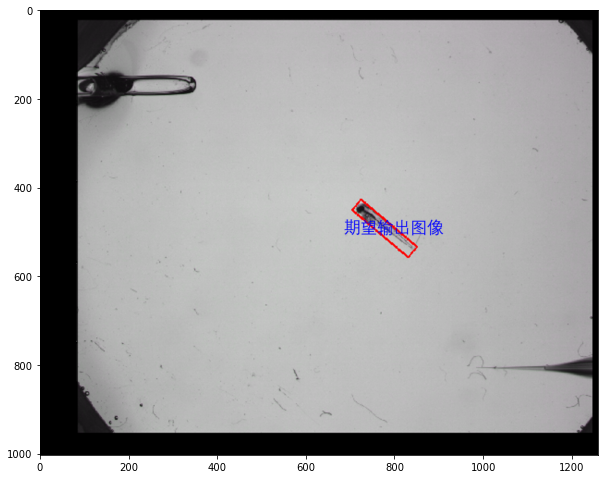

In [14]:
img_expect = cv.imread("./data/expected.png") #读取图像，存入img_origin
# img_expect[:,:,0],img_expect[:,:,1],img_expect[:,:,2]=img_expect[:,:,2],img_expect[:,:,1],img_expect[:,:,0] #RGB通道顺序调整，方便显示
plt.figure("Image",figsize=(10, 10)) # 建立画布，设置窗口大小
plt.imshow(img_expect) #显示图像